In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from keckcode.deimos import deimosmask1d

In [2]:
coadded_spectra_red = deimosmask1d.DeimosMask1d('../galaxy_spectra/0712m4_coadd.fits')

Reading 15 spectra from:
  ../galaxy_spectra/0712m4_coadd.fits


In [3]:
specid_red = [] #np.zeros(coadded_spectra.nspec)
info = coadded_spectra_red.slitinfo
#print(info)
for i in range(coadded_spectra_red.nspec):
    spec_id = '%d_%d_%d_%d' % (info['det'][i], info['slitid'][i], info['objid'][i], info['spatloc'][i])
    specid_red.append(spec_id)
    print(spec_id)

1_153_1_132
1_337_1_290
1_337_2_340
1_566_1_629
1_716_1_721
1_811_1_794
1_846_1_828
1_943_1_948
1_1081_1_1070
1_1250_1_1212
1_1325_1_1301
1_1446_1_1478
1_1504_1_1500
1_1572_1_1566
1_1844_2_1839


In [4]:
gal_spec_id = specid_red[1]
print('galaxy_spectra_id: %s' % (gal_spec_id))
data =  coadded_spectra_red[gal_spec_id]
#print(data)
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
sky_spectra_galaxy = data['sky']

galaxy_spectra_id: 1_337_1_290


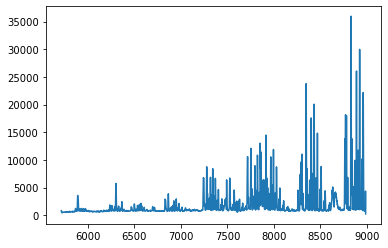

In [5]:
#%matplotlib notebook
plt.plot(lamda_galaxy, sky_spectra_galaxy)#/ np.median(sky_spectra_galaxy))
#plt.plot(lamda_galaxy, variance_spectra_galaxy)
#plt.plot(lamda_galaxy, spectra_galaxy)# / np.median(spectra_galaxy))

In [6]:
sky_lines = [(6360.31, 6371.58), (6918.69, 6930.85),
             (6945.18, 6955.71), (7311.25, 7323.89), (7335.76, 7348.45), (7365.15, 7376.92),
             (7564.66, 7580.49), (7787.00, 7802.32), (7816.66, 7829.50), (7959.25, 7973.24), 
             (7988.61, 8001.28), (8020.83, 8033.82), (8394.94, 8407.15), (8424.81, 8439.92),
             (8460.39, 8472.95), (8880.77, 8893.45), (8914.82, 8926.67), (8938.93, 8949.80)]
#(6293.89, 6312.63), (6857.52, 6875.98),(8500.58, 8512.42), (8953.37, 8964.89)

In [7]:
exact_sky_lines = []
index = []
for i,p in enumerate(sky_lines):
    a = abs(lamda_galaxy - p[0])
    b = abs(lamda_galaxy - p[1])
    a_list = a.tolist()
    b_list = b.tolist()
    start = lamda_galaxy[a_list.index(min(a))]
    stop = lamda_galaxy[b_list.index(min(b))]
    exact_sky_lines.append((start, stop))
    index.append((a_list.index(min(a)), b_list.index(min(b))))

In [8]:
print("sky_lines : \n")
[print(*line) for line in sky_lines]
print("\nexact_sky_lines : \n")
[print(*line) for line in exact_sky_lines]

sky_lines : 

6360.31 6371.58
6918.69 6930.85
6945.18 6955.71
7311.25 7323.89
7335.76 7348.45
7365.15 7376.92
7564.66 7580.49
7787.0 7802.32
7816.66 7829.5
7959.25 7973.24
7988.61 8001.28
8020.83 8033.82
8394.94 8407.15
8424.81 8439.92
8460.39 8472.95
8880.77 8893.45
8914.82 8926.67
8938.93 8949.8

exact_sky_lines : 

6360.469374880521 6371.546757331823
6918.750060406793 6930.797360002294
6945.257817889008 6955.703175239816
7311.10476665446 7324.030298752647
7336.149429249341 7348.269819530094
7365.240420713414 7376.5558976502125
7565.0059285457155 7580.381585618693
7786.771443520559 7802.149995696794
7816.715668199635 7829.666111394928
7959.114827878195 7972.861681387613
7988.225878225389 8001.163402462779
8020.563046308697 8033.499795367334
8394.846519299537 8406.910153144165
8424.598290789594 8439.871049446027
8460.759172216274 8472.806464704345
8880.953543085398 8893.647254232941
8915.05363614048 8926.95199461335
8938.816759195479 8949.898296655476


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
# empty list to contain data of these sky lines 
data_sky_line = []           
lamda_sky_line = [] 

In [12]:
lam_list = lamda_galaxy.tolist()                   # converting array to list
sky_spec_list = sky_spectra_galaxy.tolist()        # contains sky spectra data

for i,p in enumerate(exact_sky_lines):
    start = lam_list.index(p[0])
    stop  = lam_list.index(p[1])
    sky_spec = sky_spec_list[start:stop+1]   # slicing and collecting data for the wavelength range
    lam = lam_list[start:stop+1]
    #print(len(lam))
    data_sky_line.append(sky_spec)
    lamda_sky_line.append(lam)

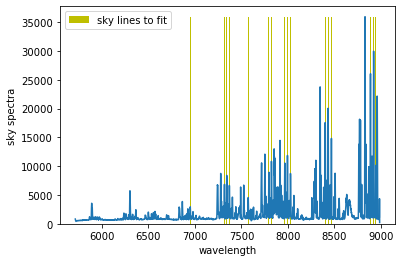

In [13]:
s = np.zeros(len(lamda_sky_line))
w = np.zeros(len(lamda_sky_line))
for i,p in enumerate(lamda_sky_line):
    s[i]= np.median(p)
    w[i]= len(p)

plt.plot(lamda_galaxy, sky_spectra_galaxy)
plt.bar(s, height=max(sky_spectra_galaxy), width=w / 2.0, color='y', label='sky lines to fit')
plt.xlabel('wavelength')
plt.ylabel('sky spectra')
plt.legend()
plt.show()

In [14]:
model_gauss = models.Gaussian1D()           # calling the Gaussian model 
fitter_gauss = fitting.LevMarLSQFitter()    # Calling the fitting scheme 

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    1.2360539975154063 -1.0682832522441825 2.086882985504968
3.596096201476555e-06


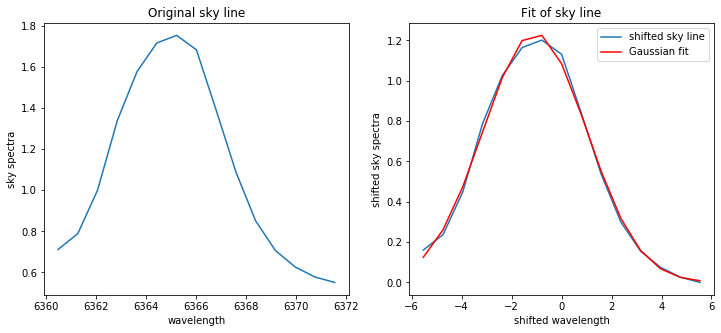

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ----------------- ------------------- -----------------
    1.359163390412137 -0.7115527027956137 2.114177340029443
0.0031495629746060004


<Figure size 432x288 with 0 Axes>

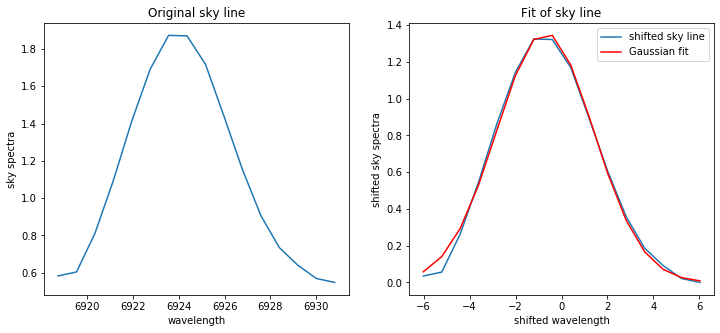

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    1.1772631731327172 -0.3969835663834813 2.0281045388534893
0.005307112384620375


<Figure size 432x288 with 0 Axes>

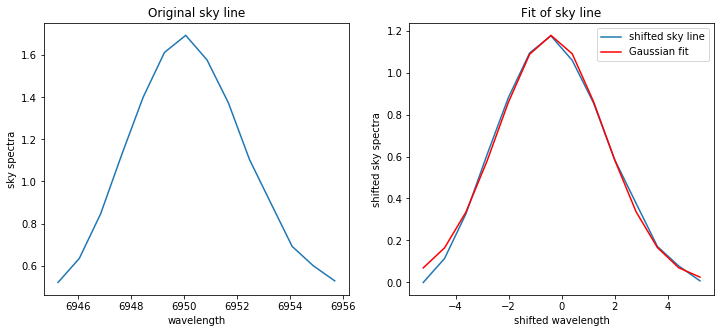

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    2.7210999465475028 -0.37475751199990887 2.1123284689653383
0.0008058834950614918


<Figure size 432x288 with 0 Axes>

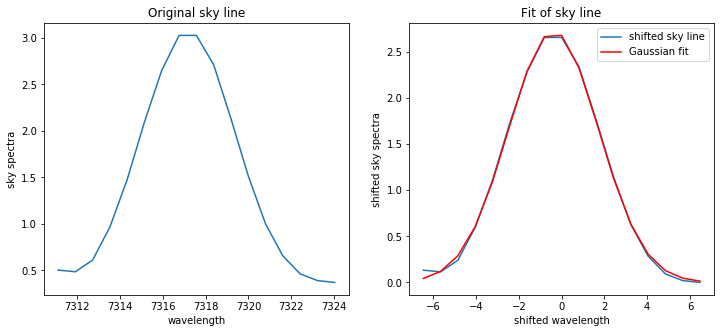

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev     
    ------------------ -------------------- -----------------
    2.4294649413469784 -0.33667454697530036 2.061517055231601
0.01411547618523101


<Figure size 432x288 with 0 Axes>

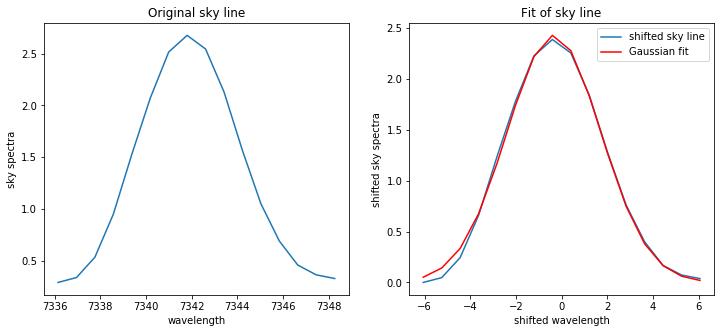

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    1.8517788856374304 -0.5409649275001122 2.0433963438701106
0.019577247905162062


<Figure size 432x288 with 0 Axes>

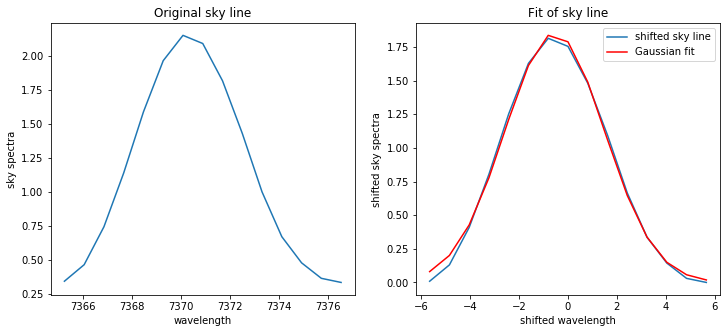

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    2.4020853084271496 0.08375596320948421 2.198982606149786
0.017405633763754192


<Figure size 432x288 with 0 Axes>

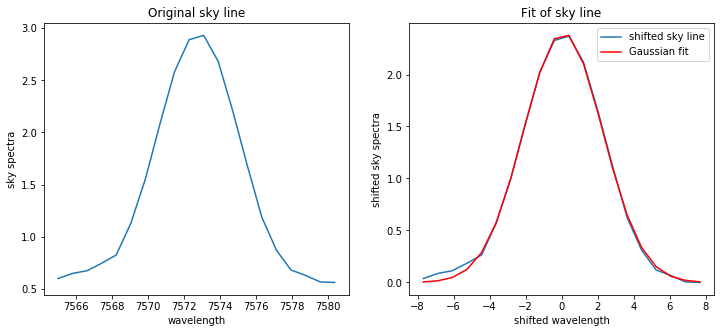

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev      
    ----------------- ------------------ ------------------
    4.145914332182634 0.6425439721134585 2.0330809274860426
0.039585621818203486


<Figure size 432x288 with 0 Axes>

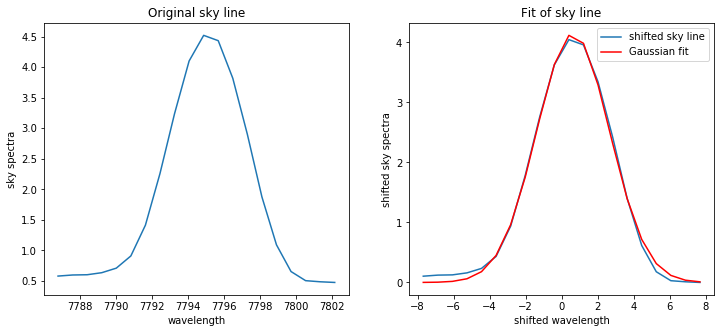

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ----------------- ------------------- -----------------
    3.341385881269864 -0.5819252328263668 1.918275746403656
0.0828850261700716


<Figure size 432x288 with 0 Axes>

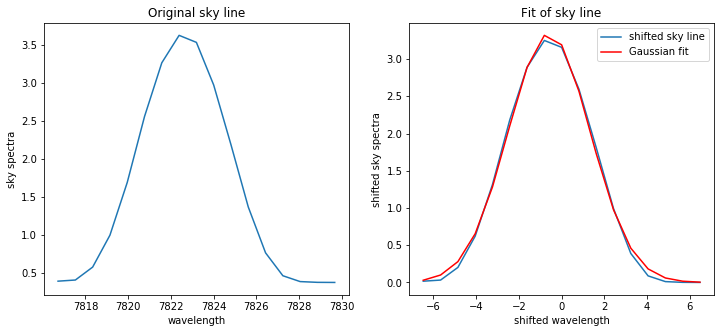

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    3.7312416013724348 -0.08657559981231783 2.0149977642770667
0.001848893673902327


<Figure size 432x288 with 0 Axes>

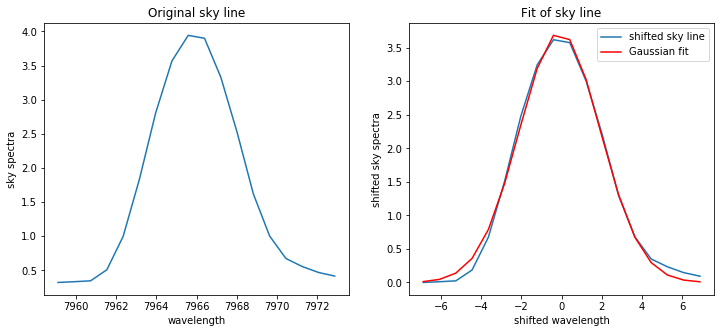

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    3.376718806506814 -0.18275993785489442 1.9162134351734925
0.08238241578814431


<Figure size 432x288 with 0 Axes>

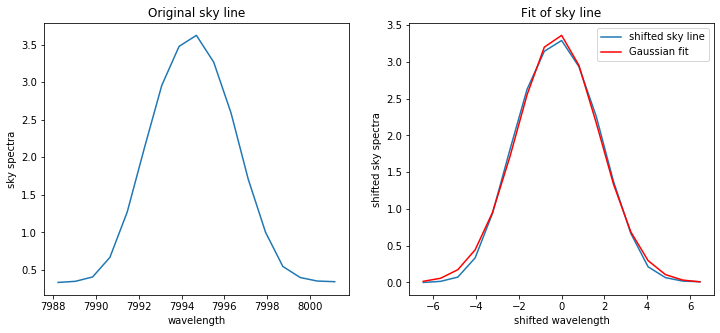

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude            mean              stddev      
    ---------------- ------------------ ------------------
    2.53827079298461 0.0936560655523119 1.9863612196334592
0.004828666890860056


<Figure size 432x288 with 0 Axes>

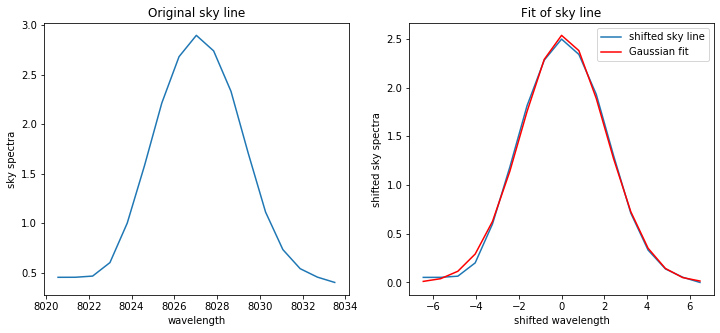

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev     
    ----------------- -------------------- -----------------
    3.914864282480673 -0.32272807996777325 1.844215212162531
0.08795172582587645


<Figure size 432x288 with 0 Axes>

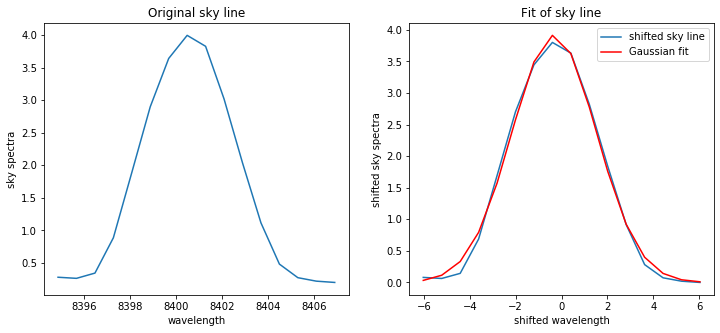

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude             mean              stddev      
    ---------------- ------------------- ------------------
    8.28723597761249 -0.6622479814238228 1.8967644882898294
0.038071513315328015


<Figure size 432x288 with 0 Axes>

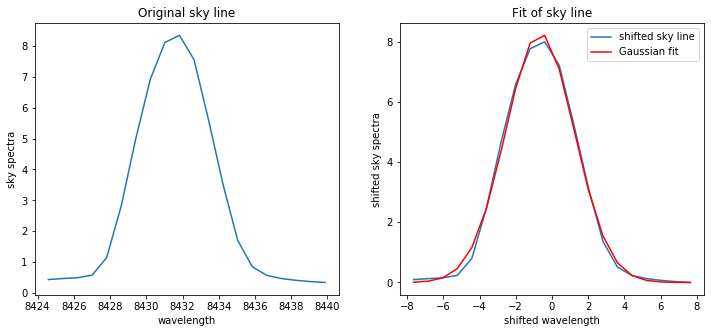

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    3.5827368760872735 -0.00941968627793637 1.8431242538735149
0.1603000060739639


<Figure size 432x288 with 0 Axes>

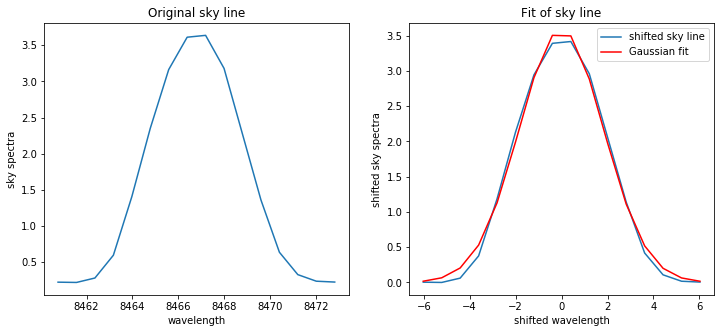

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    5.901402151521973 -0.44047666373829175 1.8707352703900761
0.19290663721921378


<Figure size 432x288 with 0 Axes>

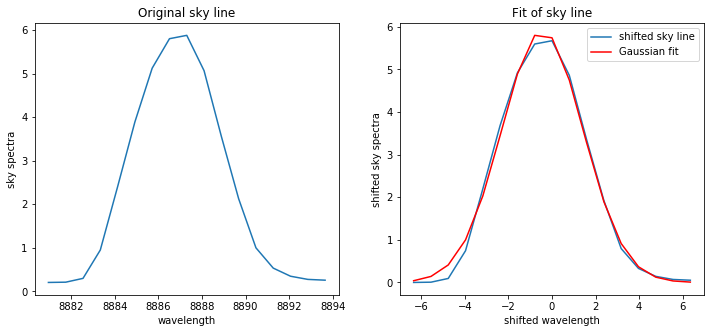

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    3.841211901039557 -0.45494270487093347 1.8602184628374534
0.06948075850630327


<Figure size 432x288 with 0 Axes>

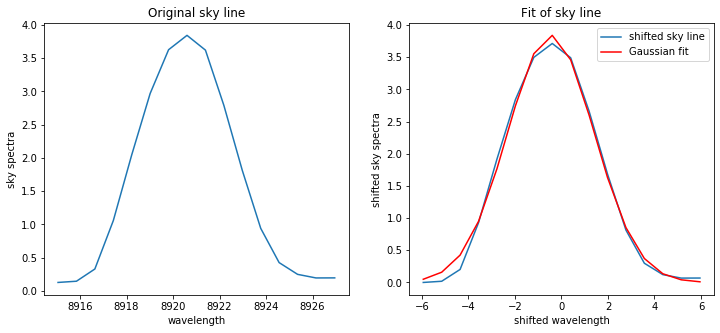

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    2.717959455769793 -0.12772929176750225 1.8550595771365366
0.06038549175661269


<Figure size 432x288 with 0 Axes>

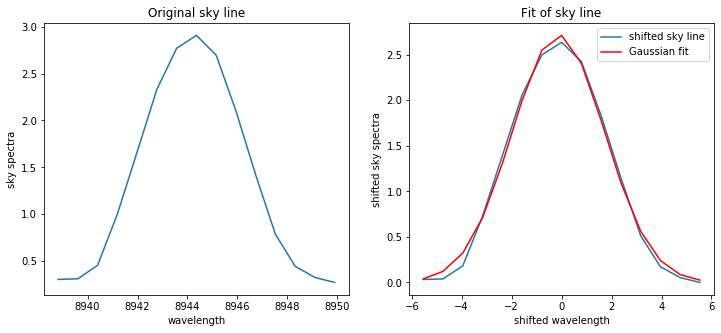

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    1.2360539975154063 -1.0682832522441825 2.086882985504968
3.596096201476555e-06


<Figure size 432x288 with 0 Axes>

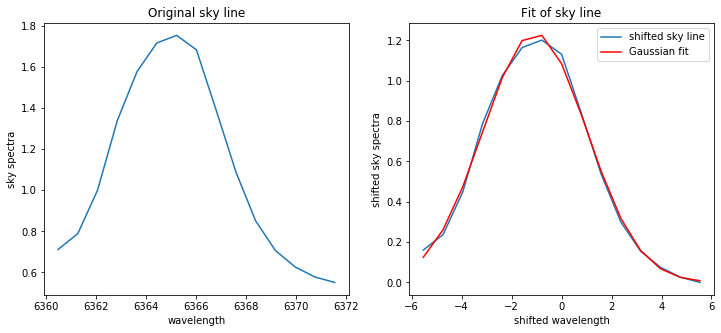

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ----------------- ------------------- -----------------
    1.359163390412137 -0.7115527027956137 2.114177340029443
0.0031495629746060004


<Figure size 432x288 with 0 Axes>

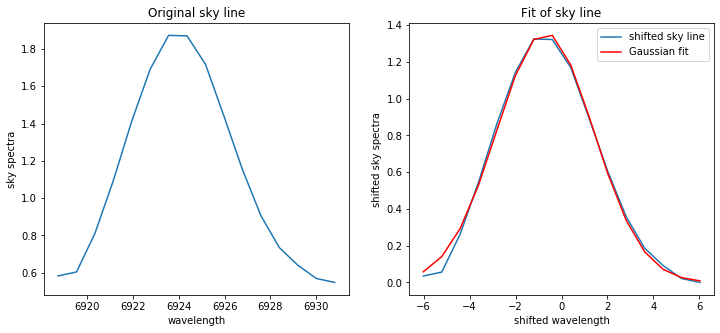

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    1.1772631731327172 -0.3969835663834813 2.0281045388534893
0.005307112384620375


<Figure size 432x288 with 0 Axes>

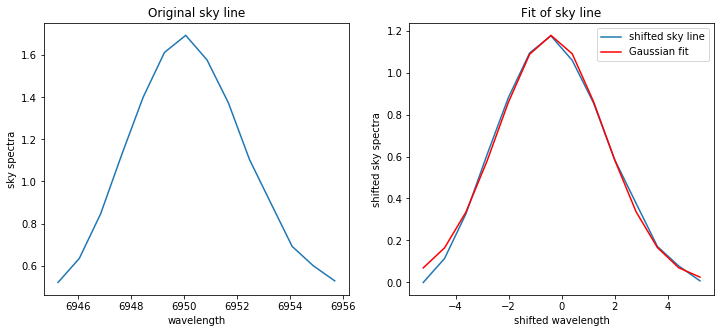

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    2.7210999465475028 -0.37475751199990887 2.1123284689653383
0.0008058834950614918


<Figure size 432x288 with 0 Axes>

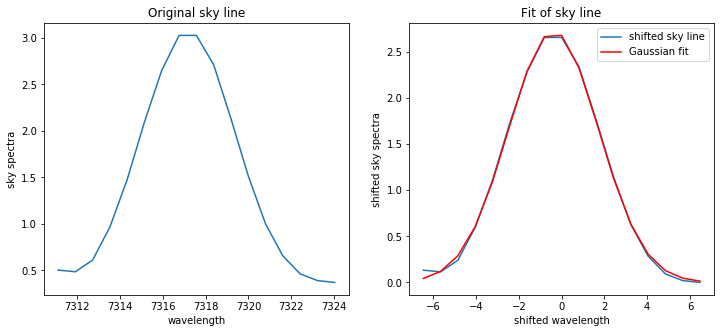

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev     
    ------------------ -------------------- -----------------
    2.4294649413469784 -0.33667454697530036 2.061517055231601
0.01411547618523101


<Figure size 432x288 with 0 Axes>

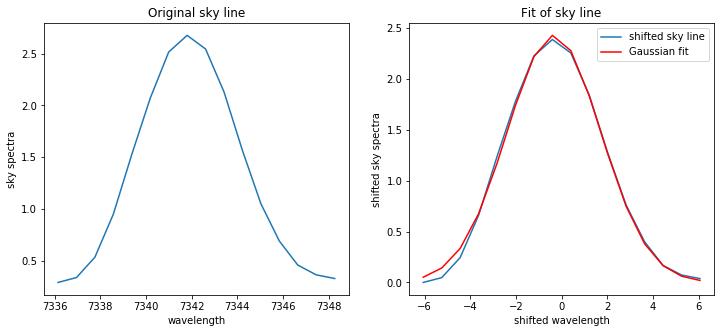

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    1.8517788856374304 -0.5409649275001122 2.0433963438701106
0.019577247905162062


<Figure size 432x288 with 0 Axes>

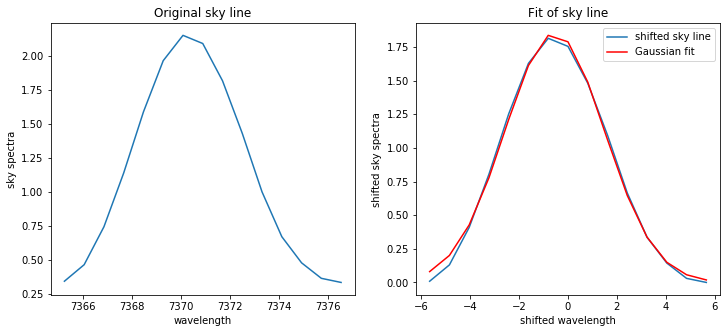

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    2.4020853084271496 0.08375596320948421 2.198982606149786
0.017405633763754192


<Figure size 432x288 with 0 Axes>

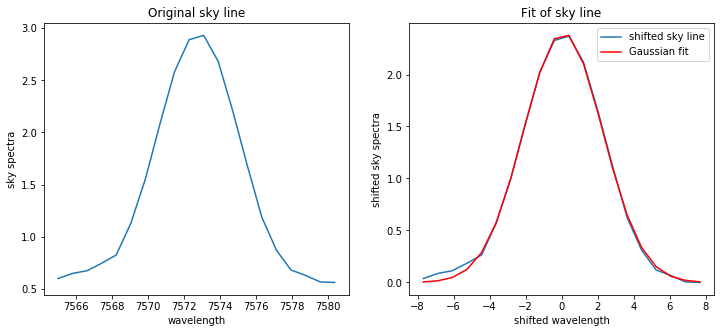

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev      
    ----------------- ------------------ ------------------
    4.145914332182634 0.6425439721134585 2.0330809274860426
0.039585621818203486


<Figure size 432x288 with 0 Axes>

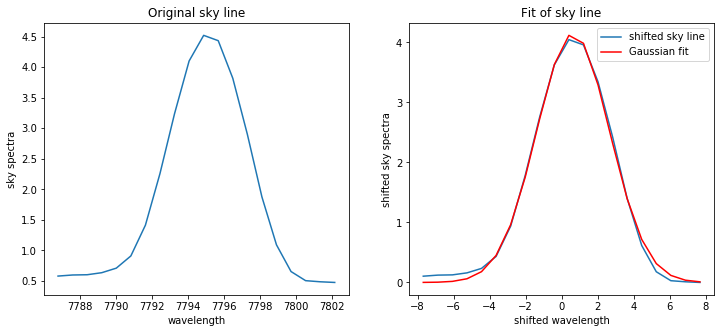

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ----------------- ------------------- -----------------
    3.341385881269864 -0.5819252328263668 1.918275746403656
0.0828850261700716


<Figure size 432x288 with 0 Axes>

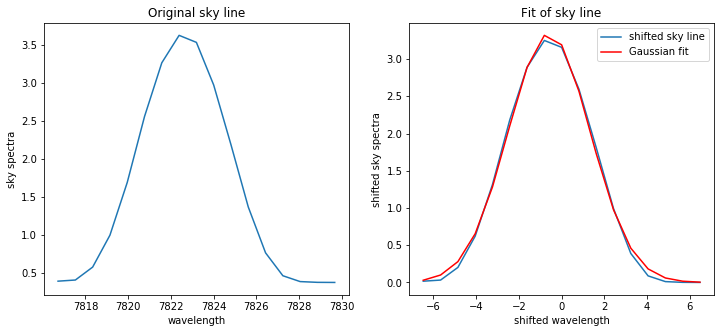

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    3.7312416013724348 -0.08657559981231783 2.0149977642770667
0.001848893673902327


<Figure size 432x288 with 0 Axes>

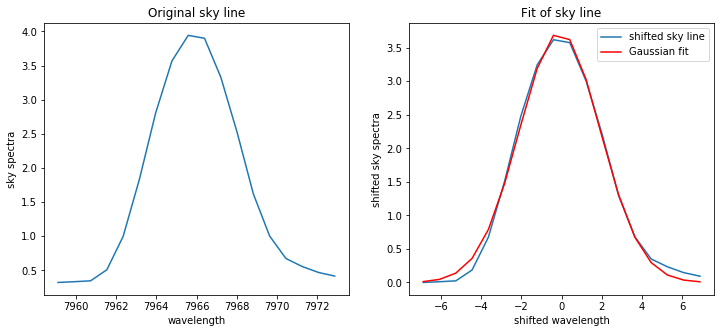

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    3.376718806506814 -0.18275993785489442 1.9162134351734925
0.08238241578814431


<Figure size 432x288 with 0 Axes>

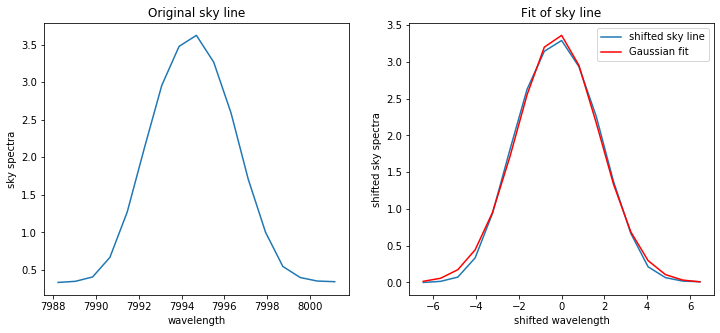

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude            mean              stddev      
    ---------------- ------------------ ------------------
    2.53827079298461 0.0936560655523119 1.9863612196334592
0.004828666890860056


<Figure size 432x288 with 0 Axes>

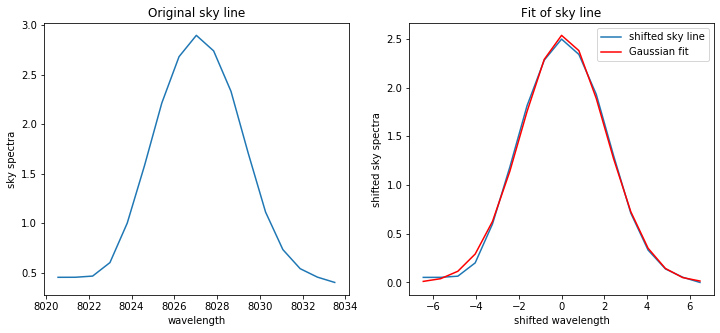

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev     
    ----------------- -------------------- -----------------
    3.914864282480673 -0.32272807996777325 1.844215212162531
0.08795172582587645


<Figure size 432x288 with 0 Axes>

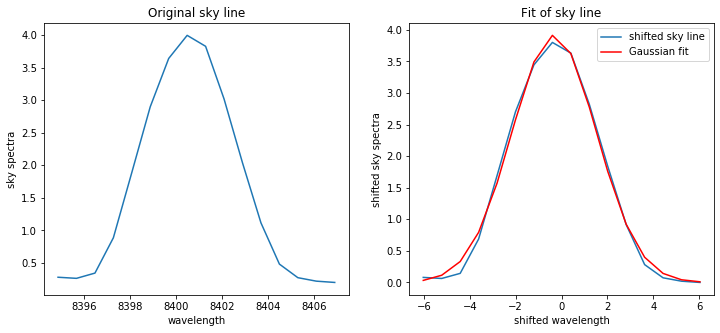

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude             mean              stddev      
    ---------------- ------------------- ------------------
    8.28723597761249 -0.6622479814238228 1.8967644882898294
0.038071513315328015


<Figure size 432x288 with 0 Axes>

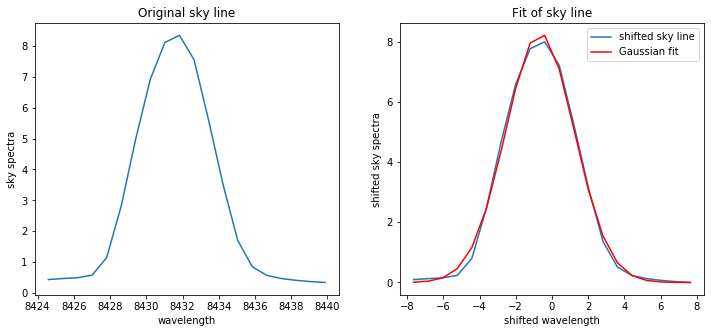

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    3.5827368760872735 -0.00941968627793637 1.8431242538735149
0.1603000060739639


<Figure size 432x288 with 0 Axes>

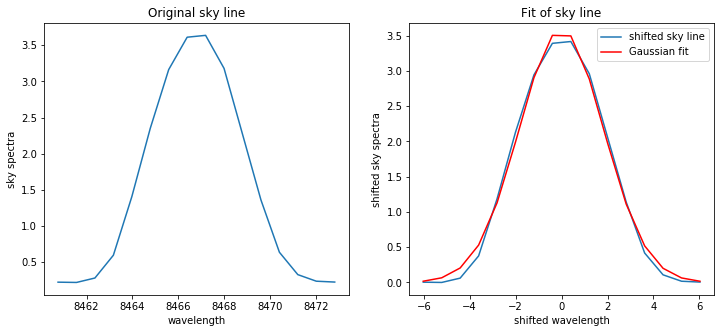

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    5.901402151521973 -0.44047666373829175 1.8707352703900761
0.19290663721921378


<Figure size 432x288 with 0 Axes>

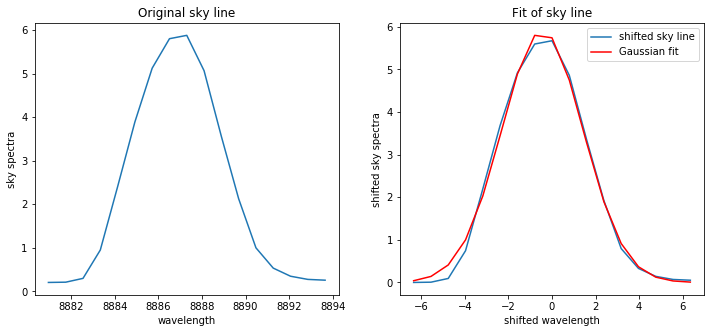

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    3.841211901039557 -0.45494270487093347 1.8602184628374534
0.06948075850630327


<Figure size 432x288 with 0 Axes>

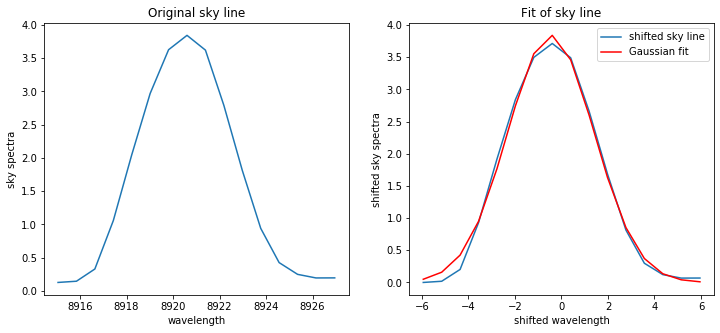

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    2.717959455769793 -0.12772929176750225 1.8550595771365366
0.06038549175661269


<Figure size 432x288 with 0 Axes>

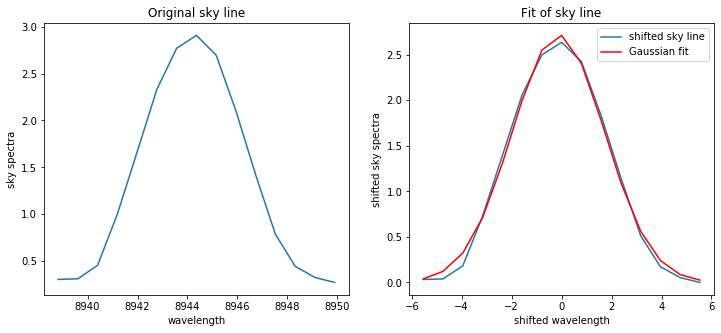

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    1.2360539975154063 -1.0682832522441825 2.086882985504968
3.596096201476555e-06


<Figure size 432x288 with 0 Axes>

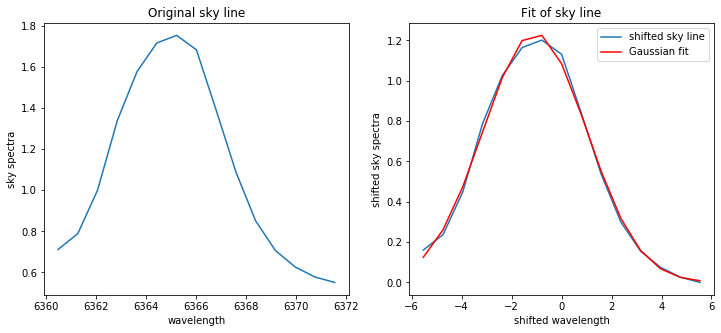

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ----------------- ------------------- -----------------
    1.359163390412137 -0.7115527027956137 2.114177340029443
0.0031495629746060004


<Figure size 432x288 with 0 Axes>

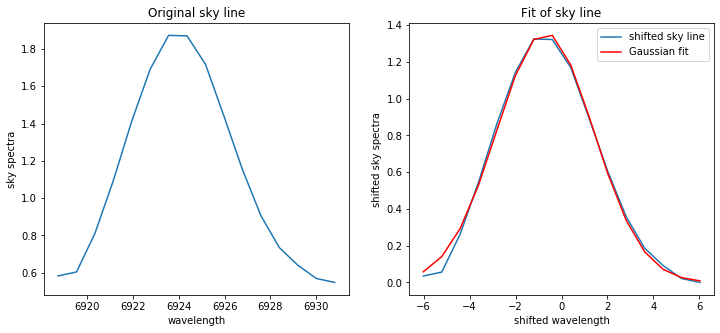

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    1.1772631731327172 -0.3969835663834813 2.0281045388534893
0.005307112384620375


<Figure size 432x288 with 0 Axes>

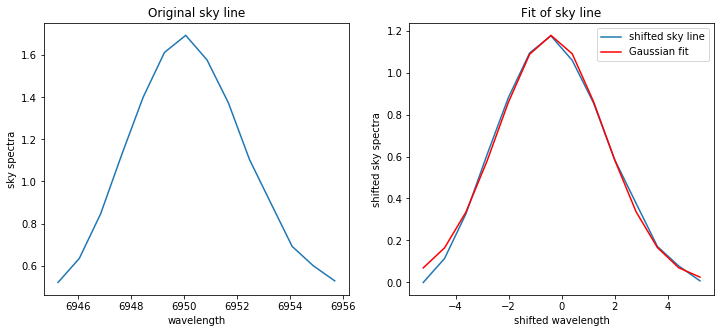

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    2.7210999465475028 -0.37475751199990887 2.1123284689653383
0.0008058834950614918


<Figure size 432x288 with 0 Axes>

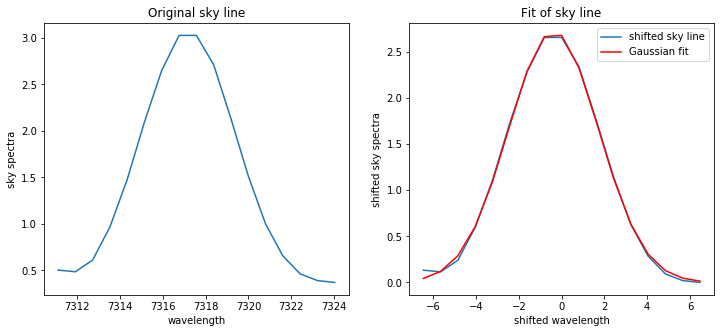

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev     
    ------------------ -------------------- -----------------
    2.4294649413469784 -0.33667454697530036 2.061517055231601
0.01411547618523101


<Figure size 432x288 with 0 Axes>

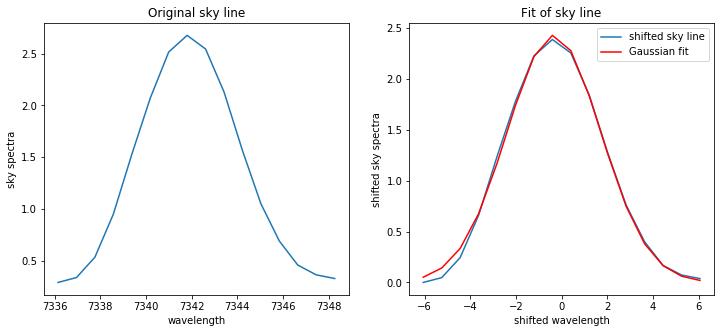

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev      
    ------------------ ------------------- ------------------
    1.8517788856374304 -0.5409649275001122 2.0433963438701106
0.019577247905162062


<Figure size 432x288 with 0 Axes>

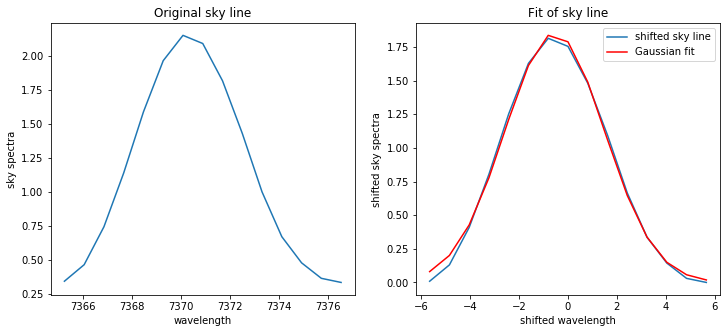

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    2.4020853084271496 0.08375596320948421 2.198982606149786
0.017405633763754192


<Figure size 432x288 with 0 Axes>

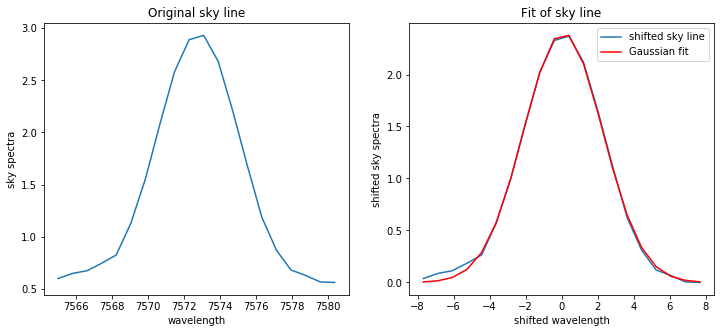

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev      
    ----------------- ------------------ ------------------
    4.145914332182634 0.6425439721134585 2.0330809274860426
0.039585621818203486


<Figure size 432x288 with 0 Axes>

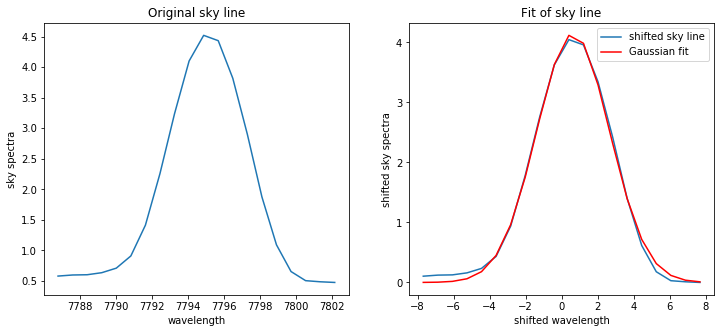

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ----------------- ------------------- -----------------
    3.341385881269864 -0.5819252328263668 1.918275746403656
0.0828850261700716


<Figure size 432x288 with 0 Axes>

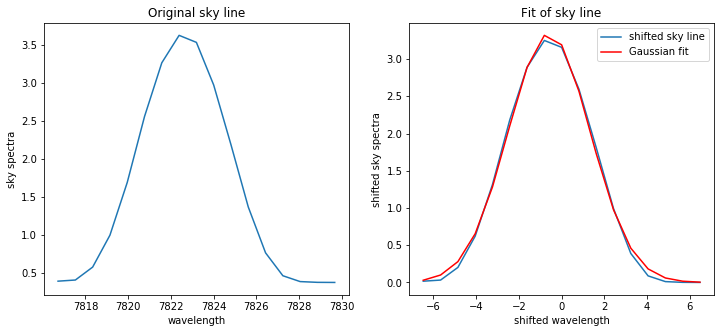

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    3.7312416013724348 -0.08657559981231783 2.0149977642770667
0.001848893673902327


<Figure size 432x288 with 0 Axes>

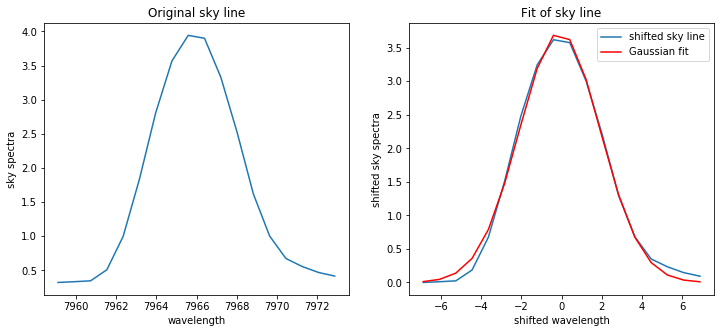

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    3.376718806506814 -0.18275993785489442 1.9162134351734925
0.08238241578814431


<Figure size 432x288 with 0 Axes>

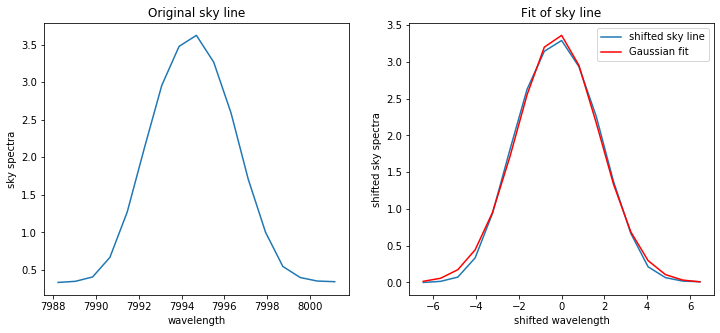

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude            mean              stddev      
    ---------------- ------------------ ------------------
    2.53827079298461 0.0936560655523119 1.9863612196334592
0.004828666890860056


<Figure size 432x288 with 0 Axes>

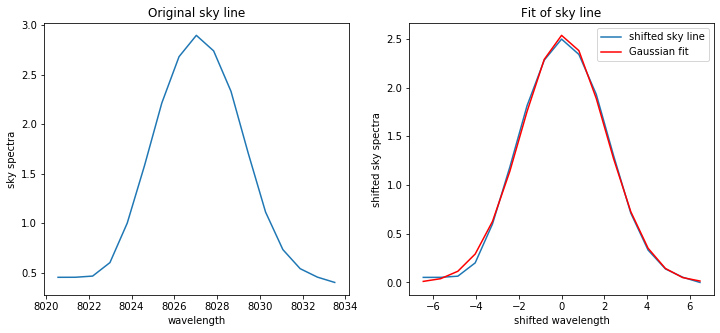

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev     
    ----------------- -------------------- -----------------
    3.914864282480673 -0.32272807996777325 1.844215212162531
0.08795172582587645


<Figure size 432x288 with 0 Axes>

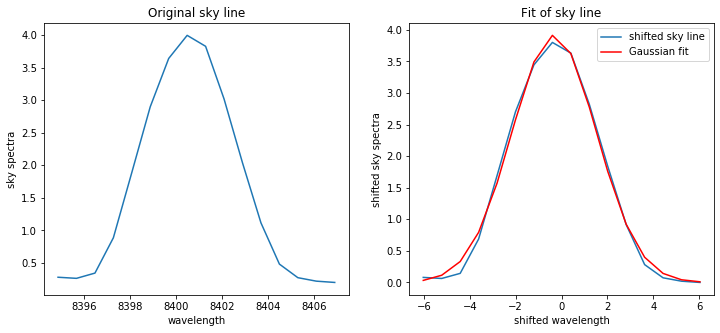

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude             mean              stddev      
    ---------------- ------------------- ------------------
    8.28723597761249 -0.6622479814238228 1.8967644882898294
0.038071513315328015


<Figure size 432x288 with 0 Axes>

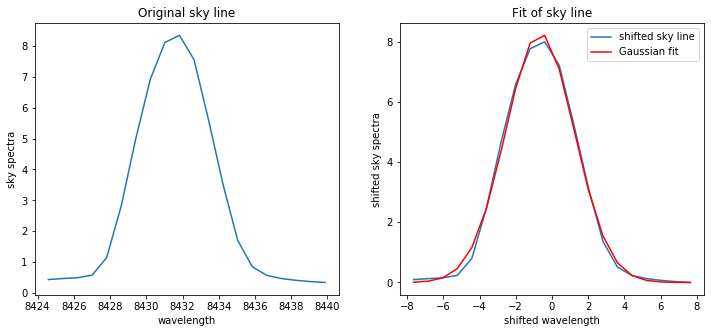

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean               stddev      
    ------------------ -------------------- ------------------
    3.5827368760872735 -0.00941968627793637 1.8431242538735149
0.1603000060739639


<Figure size 432x288 with 0 Axes>

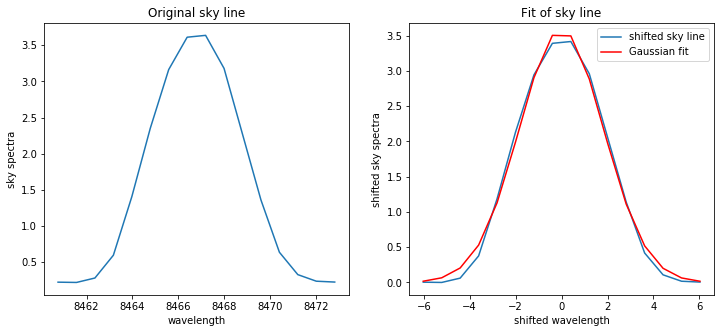

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    5.901402151521973 -0.44047666373829175 1.8707352703900761
0.19290663721921378


<Figure size 432x288 with 0 Axes>

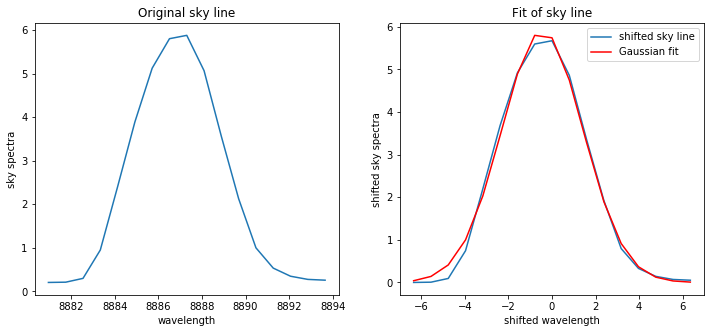

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    3.841211901039557 -0.45494270487093347 1.8602184628374534
0.06948075850630327


<Figure size 432x288 with 0 Axes>

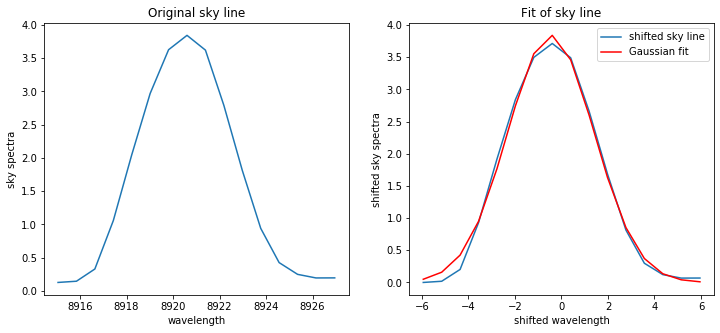

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- -------------------- ------------------
    2.717959455769793 -0.12772929176750225 1.8550595771365366
0.06038549175661269


<Figure size 432x288 with 0 Axes>

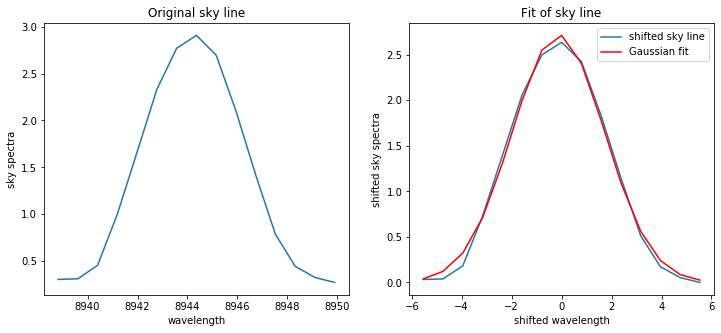

<Figure size 432x288 with 0 Axes>

In [22]:
best_fit = []
for i,p in enumerate(data_sky_line):
    data_sky_line[i] = data_sky_line[i] / np.median(data_sky_line[i])
    x = lamda_sky_line[i] - np.median(lamda_sky_line[i])
    y = data_sky_line[i] - np.min(data_sky_line[i])
    
    best_fit_gauss = fitter_gauss(model_gauss, x, y)
    best_fit.append(best_fit_gauss)
    
    print(best_fit_gauss)
    print((sum(y-best_fit_gauss(x))**2))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(lamda_sky_line[i], data_sky_line[i])
    ax1.set_title('Original sky line')
    ax1.set_xlabel('wavelength')
    ax1.set_ylabel('sky spectra')
    
     
    ax2.plot(x, y, label='shifted sky line') 
    ax2.plot(x, best_fit_gauss(x), 'r', label='Gaussian fit')
    ax2.set_title('Fit of sky line')
    ax2.set_xlabel('shifted wavelength')
    ax2.set_ylabel('shifted sky spectra')
    plt.legend()
    plt.show()
    plt.figure()

In [16]:
# Calculating the average value of the std_dev.
std = 0
for i,p in enumerate(best_fit):
    std += p.stddev.value
    #print(i)
print('average std: %f' %(std / (i+1)))
print('average fwhm: %f' %((std / (i+1))*2.355))

average std: 1.982469
average fwhm: 4.668714


Text(0, 0.5, 'std')

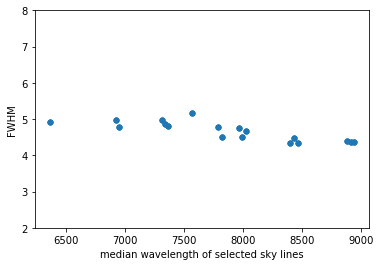

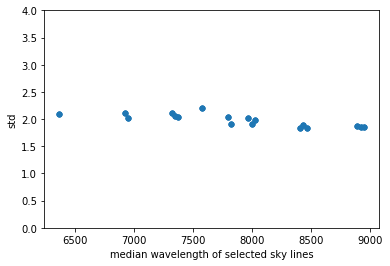

In [17]:
wav = np.zeros(len(lamda_sky_line))
#std_vl = np.zeros(len(lamda_sky_line))
fwhm = np.zeros(len(lamda_sky_line))
for i,p in enumerate(lamda_sky_line):
    wav[i] = np.median(p)
    fwhm[i] = best_fit[i].stddev.value * 2.355
plt.plot(wav, fwhm, '.', ms=10)
plt.ylim(2.0, 8.0)
plt.xlabel('median wavelength of selected sky lines')
plt.ylabel('FWHM')
plt.figure()
plt.plot(wav, fwhm/2.355, '.', ms=10)
plt.ylim(0.0, 4.0)
plt.xlabel('median wavelength of selected sky lines')
plt.ylabel('std')

In [21]:
best_fit_gauss.stddev

Parameter('stddev', value=1.8550595771365366, bounds=(1.1754943508222875e-38, None))